<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/pantompskin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [ ]:
!wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [13]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [14]:
import sys

import readin
import display

import numpy as np
from scipy import signal, ndimage

In [15]:
def pan_tompkins(input_signal, sampling_frequency, low, high):
    filtered_singal = bandpass_filter(input_signal, low, high,sampling_frequency)
    moving_avg = moving_window_integration(squaring(derivative(filtered_singal, sampling_frequency
                                            )), int(0.15*sampling_frequency))
    moving_avg[: int(0.2 * sampling_frequency)] = 0
    peaks = detect_peaks(moving_avg, sampling_frequency)

    return peaks

def detect_peaks(detection, sampling_rate=1000, **kwargs):
    """Based on https://github.com/berndporr/py-ecg-detectors/
    Optimized for vectorized computation.
    """
    min_peak_distance = int(0.3 * sampling_rate)
    min_missed_distance = int(0.25 * sampling_rate)

    signal_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    last_peak = 0
    last_index = -1

    peaks, _ = signal.find_peaks(detection, plateau_size=(1, 1))
    for index, peak in enumerate(peaks):
        peak_value = detection[peak]

        threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
        if peak_value > threshold_I1 and peak > last_peak + min_peak_distance:
            signal_peaks.append(peak)

            # RR_missed threshold is based on the previous eight R-R intervals
            if len(signal_peaks) > 9:
                RR_ave = (signal_peaks[-2] - signal_peaks[-10]) // 8
                RR_missed = int(1.66 * RR_ave)
                if peak - last_peak > RR_missed:
                    missed_peaks = peaks[last_index + 1 : index]
                    missed_peaks = missed_peaks[
                        (missed_peaks > last_peak + min_missed_distance)
                        & (missed_peaks < peak - min_missed_distance)
                    ]
                    threshold_I2 = 0.5 * threshold_I1
                    missed_peaks = missed_peaks[detection[missed_peaks] > threshold_I2]
                    if len(missed_peaks) > 0:
                        signal_peaks[-1] = missed_peaks[np.argmax(detection[missed_peaks])]
                        signal_peaks.append(peak)

            last_peak = peak
            last_index = index

            SPKI = 0.125 * peak_value + 0.875 * SPKI
        else:
            NPKI = 0.125 * peak_value + 0.875 * NPKI

    return signal_peaks

def moving_window_integration(signal, window_size):
    window_size = int(window_size)

    mwa = ndimage.uniform_filter1d(signal, window_size, origin=(window_size - 1) // 2)

    head_size = min(window_size - 1, len(signal))
    mwa[:head_size] = np.cumsum(signal[:head_size]) / np.linspace(1, head_size, head_size)
    return mwa

def squaring(input_signal):
    return np.square(input_signal)

def derivative(input_signal, sampled_frequency):
    return derivative_difference_equation(input_signal, sampled_frequency)

def bandpass_filter(input_signal, low, high, sampling_freq):
    return highpass_filter(lowpass_filter(input_signal, high, sampling_freq), low, sampling_freq)

def lowpass_filter(input_signal, cutoff, sampling_freq):
    return low_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def highpass_filter(input_signal, cutoff, sampling_freq):
    return high_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def derivative_numpy(input_signal, sampling_frequency):
    return np.diff(input_signal)

# y(n) = (1/8)*T 
#        *[-x(n-2) -2*x(n-1) +2x(n+1) +x(n+2)]
def derivative_difference_equation(input_signal, sampled_frequency):
    derived_signal = input_signal.copy()
    for index in range(len(input_signal)):
        derived_sample = derived_signal[index]
        if (index >= 2): derived_sample -= input_signal[index-2]
        if (index >= 1): derived_sample -= 2*input_signal[index-1]
        
        if (index < len(input_signal)-1): derived_sample += 2*input_signal[index+1]
        if (index < len(input_signal)-2): derived_sample += input_signal[index+2]
    
    derived_signal = derived_signal / ((1/8)*(1/sampled_frequency))
    return derived_signal

def low_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(2, cutoff_freq/(sampling_freq/2), 'low', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

def high_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(1, cutoff_freq/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

## Run Method

In [9]:
def pre_low_pass(input_signal, sampling_freq):
    sos = signal.butter(2, 0.683/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

In [10]:
def run_pantompkins(path, lead, low_cutoff, high_cutoff, sampling_freq, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= readin.get_data(example_path, leads, 0, signal_length)
    raw_samples = raw_samples.squeeze()
    
    pre_low = pre_low_pass(raw_samples, sampling_freq)

    low_pass = lowpass_filter(pre_low[100:], high_cutoff, sampling_freq)
    high_pass = highpass_filter(low_pass, low_cutoff, sampling_freq)

    derived = derivative(high_pass, sampling_freq)
    squared = squaring(derived)

    mvg = moving_window_integration(squared, int(0.15*sampling_freq))

    peaks = pan_tompkins(pre_low, sampling_freq, low_cutoff, high_cutoff)
    fig, axs = plt.subplots(8, figsize=(15, 40))
    axs[0].plot(raw_samples)
    axs[0].title.set_text('a) Raw')
    axs[1].plot(pre_low)
    axs[1].title.set_text('b) Shifted')
    axs[2].plot(high_pass)
    axs[2].title.set_text('c) Bandpass')
    axs[3].plot(derived)
    axs[3].title.set_text('d) Derivative')
    axs[4].plot(squared)
    axs[4].title.set_text('e) Squaring')
    axs[5].plot(mvg)
    axs[5].title.set_text('f) Moving Average')
    shift_back = []
    for peak in peaks:
      shift_back.append(peak+100)
    display.np_mark_peaks(axs[6], pre_low, shift_back, 'g) Peaks')
    display.np_mark_peaks(axs[7], pre_low, real_peaks, 'h) Annotations')

    real_predicted = [i for i in real_peaks if i>100]
    return shift_back, real_predicted

def evaluation(peaks, real_peaks, interval):
    check_peaks = real_peaks[1:]
    n_ref = len(check_peaks)
    n_detected = len(peaks)
    count = 0
    for i in range(n_ref):
        correct = check_peaks[i]
        found = np.where(np.logical_and(peaks>=correct-interval, peaks<=correct+interval))
        if len(found) >= 1:
            count += 1
    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": str(sensitivity*100)+'%',
              'PPV': str(ppv*100)+'%',
              'F1': str(f1*100) + '%'
              }
    return result

In [11]:
def test_pantompkins(path, lead, low_cutoff, high_cutoff, sampling_freq, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= readin.get_data(example_path, leads, 0, signal_length)
    raw_samples = raw_samples.squeeze()
    samples =raw_samples - np.mean(raw_samples)

    peaks = pan_tompkins(samples, sampling_freq, low_cutoff, high_cutoff)

    return peaks, real_peaks

## Low pass methods

In [ ]:
spath = '/content/physionet.org/files/nsrdb/1.0.0/16272'
print('Clean Signal')
peaks, real_peaks = run_pantompkins(spath, 'ECG1', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

In [8]:
annots = wfdb.rdann('../../datasets/mit-af/07162', 'atr', sampfrom=0, sampto=1000)
annots.sample

NameError: ignored

In [ ]:
print('AF Signal')
peaks, real_peaks = run_pantompkins('....//datasets/mit-af/07162', 'ECG2', 5, 128, 1000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

## Run on Whole Dataset

In [2]:
import os
import glob

In [3]:
arr = os.listdir('/content/physionet.org/files/nsrdb/1.0.0')

sample_ids = []
for file in arr:
    if '.atr' in file:
        sample_ids.append(file[:5])
        

In [4]:
root_folder = '/content/physionet.org/files/nsrdb/1.0.0/'
sensitivity = []
ppv = []
f1 = []


In [5]:
sensitivity

[]

In [6]:
for id in sample_ids[8:]:
    sample_path = root_folder + id
    peaks, real_peaks = run_pantompkins(sample_path, 'ECG2', 5, 11, 128, 60*60*128)
    print('hi')
    res = evaluation(peaks, real_peaks, int(150/(1000/128)))
    sensitivity.append(res['sensitivity'])
    ppv.append(res['PPV'])
    f1.append(res['F1'])

NameError: ignored

In [ ]:
def to_float(arr):
    ret = []
    for x in arr:
        ret.append(float(x[0:-1]))
    return ret 

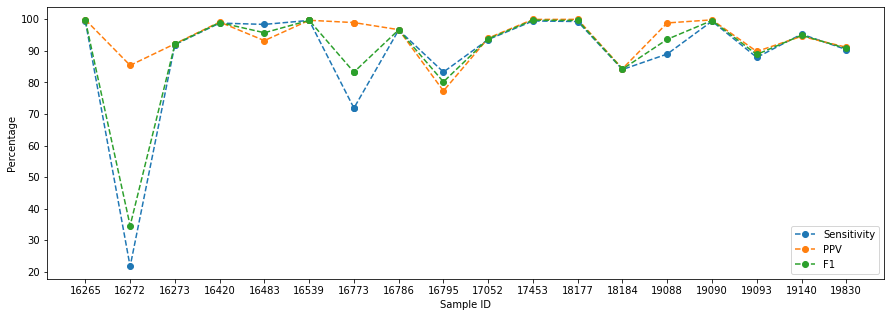

In [ ]:
plt.figure(figsize=(15,5))
plt.xlabel('Sample ID')
plt.ylabel('Percentage')

plt.plot(sample_ids, to_float(sensitivity), label='Sensitivity', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(ppv), label='PPV', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(f1), label='F1', marker='o', linestyle='--')

plt.legend()

In [ ]:
np.average(to_float(sensitivity)), np.average(to_float(ppv)), np.average(to_float(f1))

(88.70252930995336, 94.52263293614219, 90.48624490723604)